# EDA Topics Part 2 – CNN Image Processing, Transforms & Dataset Exploration

In this notebook we will:

- Load a sample image from the MNIST dataset.
- Apply several image transforms including:
  - **Normalization**
  - **Rotation**
  - **Cropping**
  - **Masking** (by zeroing out a random region)
  - **Fuzzing / Adding Noise** (by injecting Gaussian noise)
  - **Brightness Adjustment**
- Define a custom CNN (with LeakyReLU) and run a forward pass.
- Compare the effect of these transforms on the CNN output via visualization.
- Perform additional EDA on the MNIST dataset including:
  - Analyzing the label distribution
  - Displaying sample images for each class
  - Plotting pixel intensity histograms
  - Visualizing a PCA projection of the dataset


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Custom Transformations

We will create two custom transforms:

1. **RandomMask**: Masks a random rectangular area in the image (sets that region to 0).  
   
   *Why?*   
   In real-world scenarios, parts of an image might be occluded. This helps simulate occlusion and test the robustness of the model.

2. **AddGaussianNoise**: Adds Gaussian noise to the image.
   
   *Why?*   
   Noise is common in real data (e.g., sensor noise). This transform tests how well the CNN handles noisy inputs.

In [2]:
class RandomMask(object):
    def __init__(self, mask_size=(10, 10)):
        """
        Args:
            mask_size (tuple): Size of the mask (height, width).
        """
        self.mask_size = mask_size

    def __call__(self, img):
        """
        Args:
            img (Tensor): Image tensor of shape [C, H, W].
        Returns:
            Tensor: Image with a random rectangular region masked (set to 0).
        """
        _, h, w = img.shape
        mask_h, mask_w = self.mask_size

        # ensure the mask fits inside the image.
        if h - mask_h <= 0 or w - mask_w <= 0:
            return img  # skip masking if image is too small.

        top = random.randint(0, h - mask_h)
        left = random.randint(0, w - mask_w)

        img[:, top:top+mask_h, left:left+mask_w] = 0
        return img


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        """
        Args:
            mean (float): Mean of the Gaussian noise.
            std (float): Standard deviation of the noise.
        """
        self.mean = mean
        self.std = std

    def __call__(self, img):
        """
        Args:
            img (Tensor): Image tensor.
        Returns:
            Tensor: Image with added Gaussian noise.
        """
        noise = torch.randn(img.size()) * self.std + self.mean
        noisy_img = img + noise
        # clamp to keep pixel values in a valid range.
        return torch.clamp(noisy_img, 0., 1.)

## Load a Sample Image from MNIST

We use MNIST because its images are grayscale (1 channel) and have size 28×28—compatible with our CNN.

We first load one image with the basic `ToTensor()` transform.

Random index: 7360
Label: 2
Image tensor shape: torch.Size([1, 28, 28])


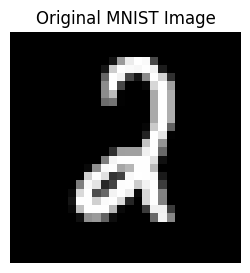

In [63]:
# define a simple transform: convert image to tensor.
basic_transform = transforms.ToTensor()

# download the MNIST training dataset.
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=basic_transform)

# an image is randomly chosen from the dataset
random_index = random.randint(1, 10000)
print(f"Random index: {random_index}")


# get one sample image and its label.
img, label = mnist_dataset[random_index]
print(f"Label: {label}")
print(f"Image tensor shape: {img.shape}")

# display the original image.
plt.figure(figsize=(3,3))
plt.imshow(img.squeeze(), cmap='gray')
plt.title("Original MNIST Image")
plt.axis('off')
plt.show()

## 1. Normalization

Normalization helps standardize the pixel values. For MNIST, typical values are:

- **Mean** ≈ 0.1307
- **Std** ≈ 0.3081

*Why?*  
 Normalizing the input ensures that the model sees data on a common scale, which can speed up training and improve performance.

In [64]:
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(mnist_dataset.data.min(), mnist_dataset.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(mnist_dataset.data.float().mean(), mnist_dataset.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(mnist_dataset.data.float().mean() / 255, mnist_dataset.data.float().std() / 255))

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 33.31842041015625 
Pixel Values Std: 78.56748962402344
Scaled Mean Pixel Value 0.13066047430038452 
Scaled Pixel Values Std: 0.30810779333114624


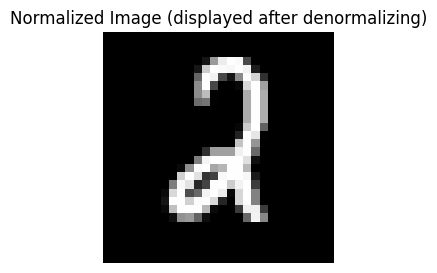

In [65]:
normalize_transform = transforms.Normalize((0.1307,), (0.3081,))

# normalize the image
normalized_img = normalize_transform(img)

# to display the normalized image, we reverse the normalization
def denormalize(tensor, mean, std):
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

denorm_img = denormalize(normalized_img, (0.1307,), (0.3081,))

plt.figure(figsize=(3,3))
plt.imshow(denorm_img.squeeze(), cmap='gray')
plt.title("Normalized Image (displayed after denormalizing)")
plt.axis('off')
plt.show()

## 2. Rotation

We can rotate an image by a specified degree. Here we use a fixed rotation of 30°.

*Why?*  
 Rotation tests the model’s ability to recognize objects regardless of their orientation.

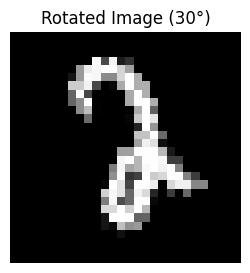

In [66]:
rotation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation((30, 30)),  # fixed 30° rotation
    transforms.ToTensor()
])

rotated_img = rotation_transform(img)

plt.figure(figsize=(3,3))
plt.imshow(rotated_img.squeeze(), cmap='gray')
plt.title("Rotated Image (30°)")
plt.axis('off')
plt.show()

## 3. Cropping

Cropping focuses on a part of the image. Here we perform a random crop of size 24×24 from the original 28×28 image.

*Why?*  
Cropping simulates situations where only a part of the object is visible (e.g., due to framing or occlusion).

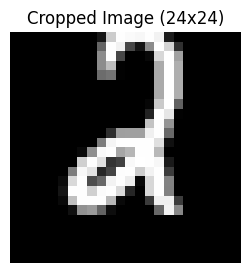

In [67]:
crop_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(24),
    transforms.ToTensor()
])

cropped_img = crop_transform(img)

plt.figure(figsize=(3,3))
plt.imshow(cropped_img.squeeze(), cmap='gray')
plt.title("Cropped Image (24x24)")
plt.axis('off')
plt.show()

## 4. Masking

We now use our custom **RandomMask** transform to zero out a random 10×10 patch of the image.

*Why?*   
This simulates occlusion where a part of the object is blocked, testing the model's ability to handle incomplete data.

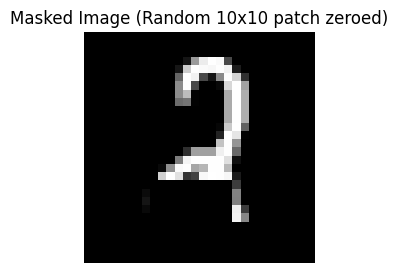

In [68]:
mask_transform = transforms.Compose([
    transforms.ToTensor(),  # ensure we have a tensor
    RandomMask(mask_size=(10, 10))
])

# convert the image to a numpy array (simulate working with a PIL image)
masked_img = mask_transform(np.array(img.squeeze()*255, dtype=np.uint8))

# if pixel values are above 1, normalize them to [0, 1]
if masked_img.max() > 1:
    masked_img = masked_img / 255.0

plt.figure(figsize=(3,3))
plt.imshow(masked_img.squeeze(), cmap='gray')
plt.title("Masked Image (Random 10x10 patch zeroed)")
plt.axis('off')
plt.show()

## 5. Fuzzing / Adding Noise

Finally, we use our custom **AddGaussianNoise** transform to add random Gaussian noise to the image.

*Why?*  
 Noise is inherent in real-world data. This helps us understand how robust the model is against noisy inputs.

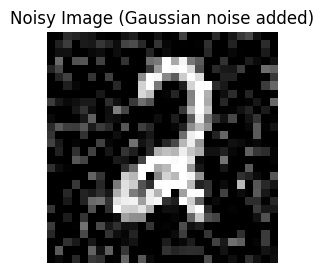

In [69]:
noise_transform = transforms.Compose([
    transforms.ToTensor(),  # ensure we have a tensor
    AddGaussianNoise(mean=0., std=0.2)
])

noisy_img = noise_transform(np.array(img.squeeze()*255, dtype=np.uint8))
if noisy_img.max() > 1:
    noisy_img = noisy_img / 255.0

plt.figure(figsize=(3,3))
plt.imshow(noisy_img.squeeze(), cmap='gray')
plt.title("Noisy Image (Gaussian noise added)")
plt.axis('off')
plt.show()

## 5. Brighten

Finally, we use a simple brighten transformation to increase the brightness of the image.

*Why?*  
Changes in lighting conditions can affect image quality. This transformation simulates an environment with higher brightness.

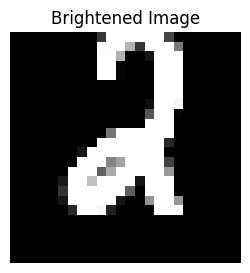

In [96]:
# define a simple brighten function.
def brighten(tensor, factor=1.5):
    # Multiply the image tensor by the brightness factor and clamp the values between 0 and 1.
    return torch.clamp(tensor * factor, 0, 1)

# we brighten the image by a factor of 2.5.
bright_img = brighten(img, factor=2.5)

plt.figure(figsize=(3, 3))
plt.imshow(bright_img.squeeze(), cmap='gray')
plt.title("Brightened Image")
plt.axis('off')
plt.show()

## Custom CNN Definition

Below is our custom CNN using two convolutional layers, max pooling, dropout, and LeakyReLU. Its the same one we used in the previous notebooks.

The architecture is as follows:

- **Conv1**: 1 → 8 channels
- **Conv2**: 8 → 16 channels
- Two max-pooling layers (reducing 28×28 to 7×7 after two rounds)
- A bottleneck fully connected layer (embedding space)
- Final classification layer

**Note:** The network expects input images of size 28×28. For transformed images (e.g., cropped), we will resize them to 28×28 before feeding them to the CNN.

In [70]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10, kernel_size=3, stride=1, padding=1, dropout_prob=0.5):
        """
        Custom CNN with LeakyReLU to prevent dead neurons.

        Args:
            num_classes (int): Number of output classes.
            kernel_size (int): Size of the convolutional kernel.
            stride (int): Stride length for convolution.
            padding (int): Padding for convolution.
            dropout_prob (float): Dropout probability.
        """
        super(CustomCNN, self).__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel_size, stride=stride, padding=padding)

        # pooling and dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial size by half
        self.dropout = nn.Dropout(dropout_prob)  # Regularization

        # activation function (LeakyReLU instead of ReLU)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)  # Prevents dead neurons

        # fully connected layers
        self.fc1 = nn.Linear(16 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, num_classes)  # final classification layer

    def forward(self, x):
        """
        Forward pass with LeakyReLU.
        """
        x = self.leaky_relu(self.conv1(x))
        x = self.pool(x)

        x = self.leaky_relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)

        out = self.fc2(x)  # final classification layer

        return out  # return only logits

In [71]:
# Instantiate the model
model = CustomCNN(num_classes=10)

## Comparative EDA: Effects of Transformations on CNN Output

In this section, we apply several transformations to the original MNIST image and pass each transformed image through the CNN. This allows us to compare how different alterations affect the model's predictions.

Each transformation simulates a real-world scenario:

- **Rotated (30°):** Tests model invariance to orientation changes.
- **Cropped (24×24):** Simulates partial views or misalignment.
- **Masked (10×10):** Simulates occlusion in images.
- **Noisy (Gaussian):** Tests robustness to noise.
- **Brighter:** Simulates changes in lighting conditions.

For each transformation, we display the transformed image alongside a bar chart showing the CNN's output probabilities (after applying softmax).

In [99]:
lr = 0.001
epochs = 5

In [100]:
# simple training loop for the CNN on MNIST
from torch.utils.data import DataLoader
import torch.optim as optim

# create data loader
train_loader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)



for epoch in range(epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        # ensure inputs have shape [B, C, H, W]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete.")

Epoch 1, Loss: 0.0777
Epoch 2, Loss: 0.0671
Epoch 3, Loss: 0.0573
Epoch 4, Loss: 0.0519
Epoch 5, Loss: 0.0465
Training complete.


In [81]:
import torch
import torch.nn.functional as F

# Ensure the image is 28x28 (required by the CNN).
def prepare_for_cnn(img_tensor):
    # img_tensor is assumed to have shape (C, H, W)
    if img_tensor.shape[1:] != (28, 28):
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(28, 28), mode='bilinear', align_corners=False).squeeze(0)
    return img_tensor

In [97]:
# example list of images (each image should be a tensor of shape [C, H, W])
images = [
    ("Original Image", img),
    ("Normalized Image", denorm_img),
    ("Masked Image", masked_img),
    ("Noisy Image", noisy_img),
    ("Rotated Image", rotated_img),
    ("Cropped Image", cropped_img),
    ("Brightened Image", bright_img)
]

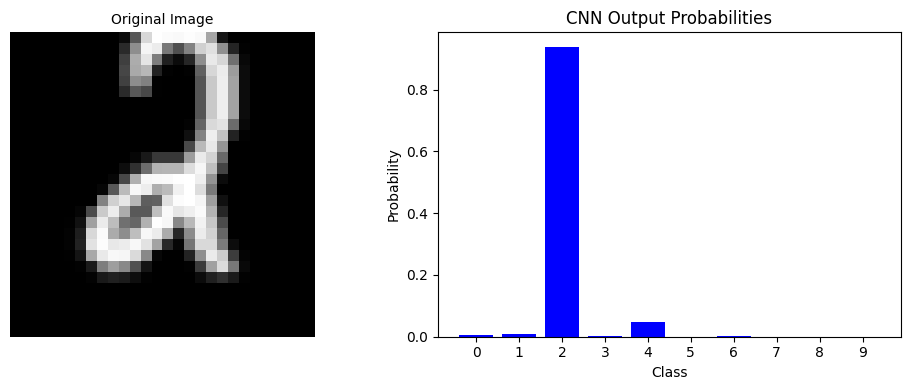

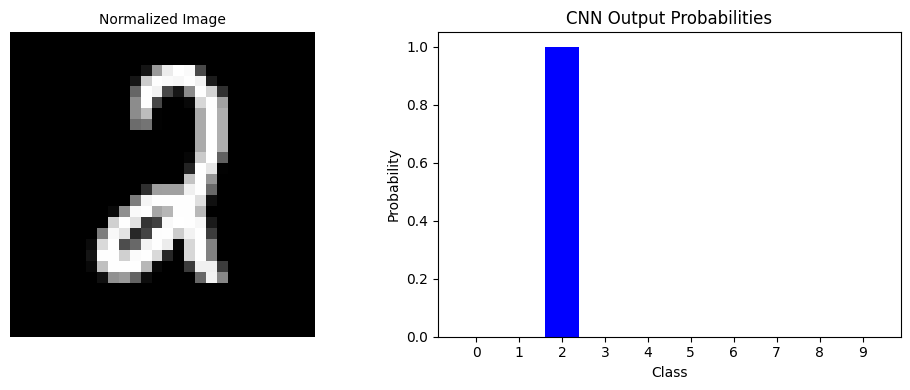

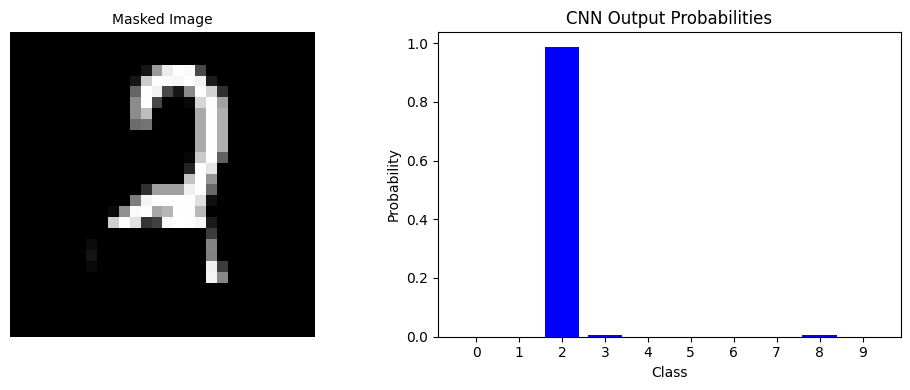

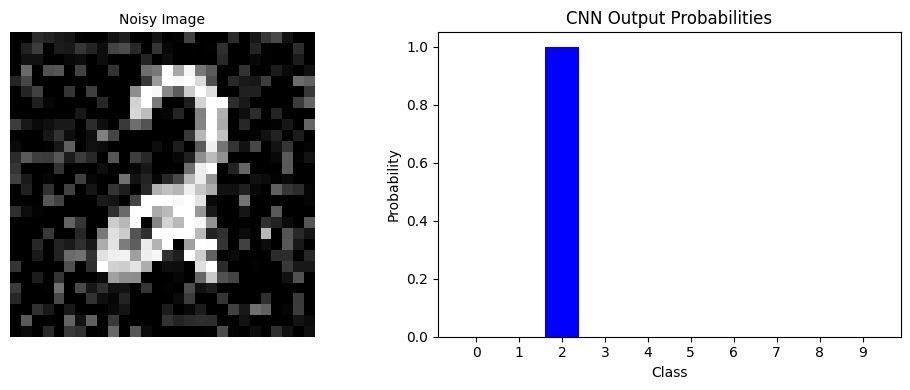

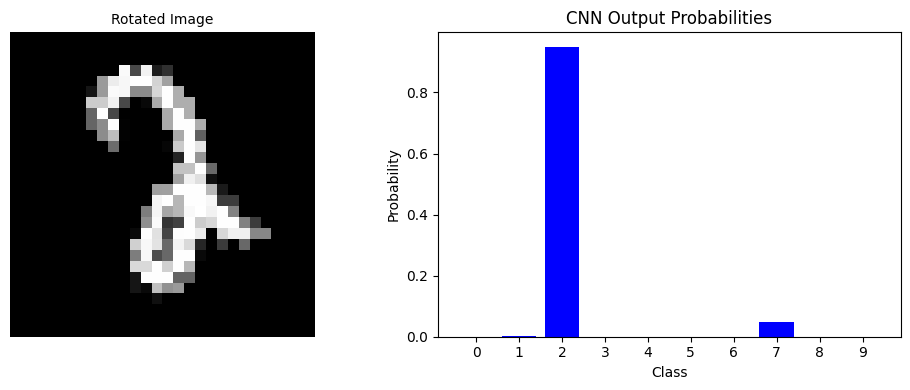

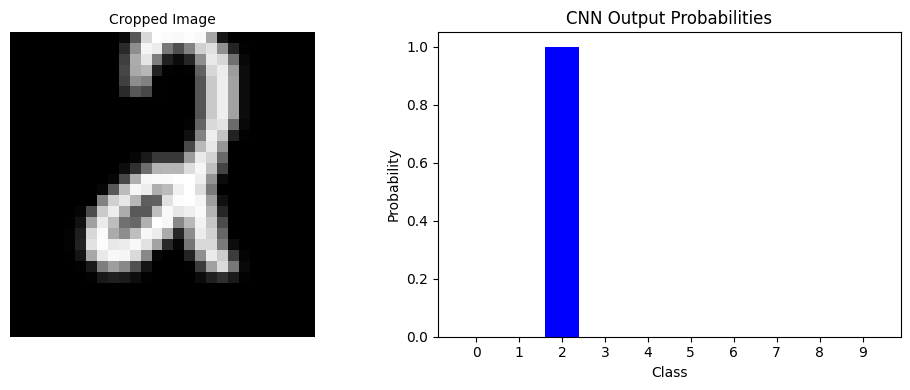

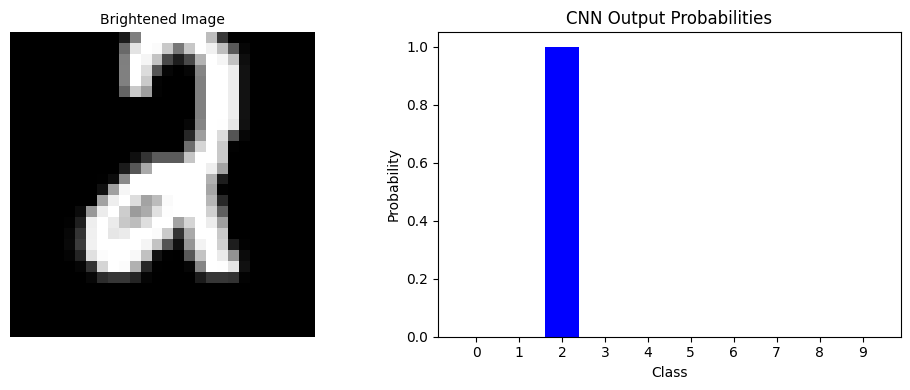

In [98]:
import matplotlib.pyplot as plt

for name, img in images:    # if the image is not a tensor, convert it
    if not torch.is_tensor(img):
        img = torch.tensor(img, dtype=torch.float32)

    # ensure the image has a channel dimension (if it's [H, W], add one)
    if img.ndim == 2:
        img = img.unsqueeze(0)

    # resize to 28x28 if needed.
    prepared_img = prepare_for_cnn(img)

    # add a batch dimension (resulting shape: [1, C, H, W]) and pass it to the CNN
    output_logits = model(prepared_img.unsqueeze(0))
    probabilities = torch.softmax(output_logits, dim=1).detach().numpy().squeeze()

    # plot the image and a bar chart of the CNN output probabilities.
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # display the image
    ax[0].imshow(prepared_img.squeeze(), cmap='gray')
    ax[0].set_title(f"{name}", fontsize=10)
    ax[0].axis('off')

    # display the CNN output as a bar chart
    classes = list(range(10))
    ax[1].bar(classes, probabilities, color='blue')
    ax[1].set_xlabel("Class")
    ax[1].set_ylabel("Probability")
    ax[1].set_title("CNN Output Probabilities")
    ax[1].set_xticks(classes)

    plt.tight_layout()
    plt.show()

## Additional EDA: MNIST Dataset Summary

In this section, we analyze the MNIST training dataset. We examine the distribution of labels, display sample images for each class, and analyze the pixel intensity distribution.

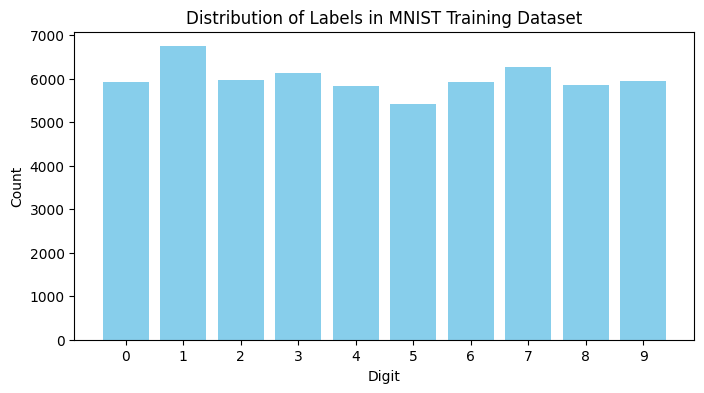

Label counts: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


In [77]:
import numpy as np

# MNIST dataset labels are available in mnist_dataset.targets
labels = mnist_dataset.targets.numpy()
label_counts = np.bincount(labels)

plt.figure(figsize=(8,4))
plt.bar(range(10), label_counts, color='skyblue')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.title('Distribution of Labels in MNIST Training Dataset')
plt.xticks(range(10))
plt.show()

print('Label counts:', label_counts)

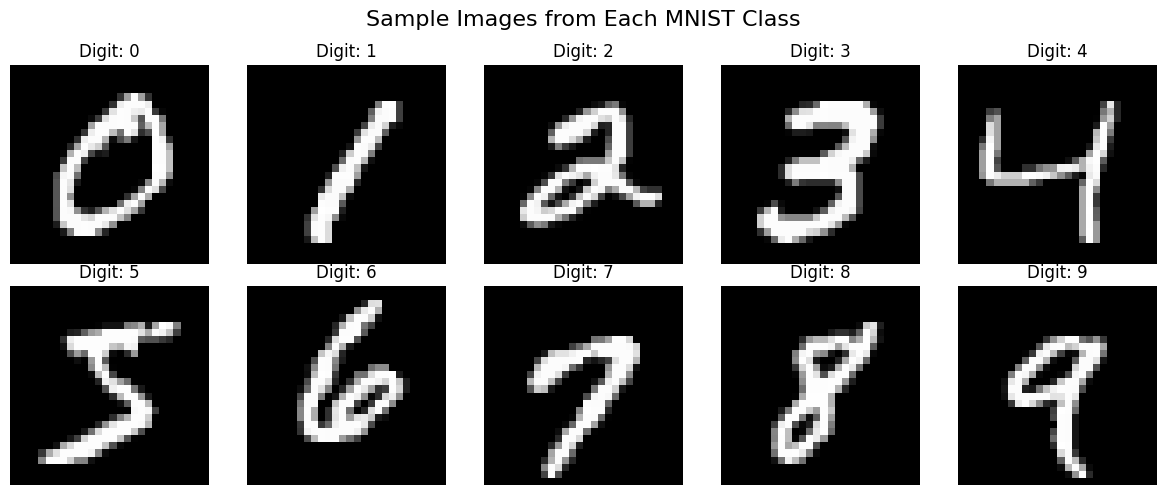

In [78]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))
fig.suptitle('Sample Images from Each MNIST Class', fontsize=16)

for digit in range(10):
    # find the first index in the dataset for this digit
    idx = (np.array(mnist_dataset.targets) == digit).nonzero()[0][0]
    sample_img, _ = mnist_dataset[idx]
    ax = axes[digit//5, digit%5]
    ax.imshow(sample_img.squeeze(), cmap='gray')
    ax.set_title(f'Digit: {digit}')
    ax.axis('off')

plt.tight_layout()
plt.show()

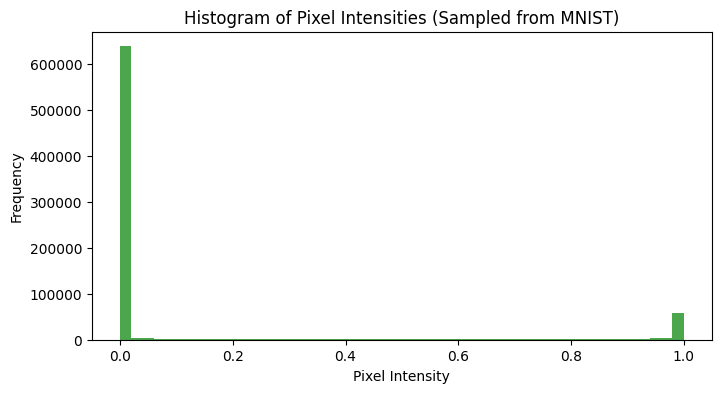

In [79]:
# sample 1000 images from the dataset and compute pixel intensity histogram
num_samples = 1000
sample_indices = np.random.choice(len(mnist_dataset), num_samples, replace=False)
all_pixels = []
for idx in sample_indices:
    img_sample, _ = mnist_dataset[idx]
    # flatten the image
    all_pixels.extend(img_sample.flatten().numpy())

plt.figure(figsize=(8,4))
plt.hist(all_pixels, bins=50, color='green', alpha=0.7)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Intensities (Sampled from MNIST)')
plt.show()

## Additional EDA: PCA Visualization of MNIST

Here, we use Principal Component Analysis (PCA) to reduce the dimensionality of MNIST images and visualize them in 2D. This helps us understand how well the data separates by class in a low-dimensional space.

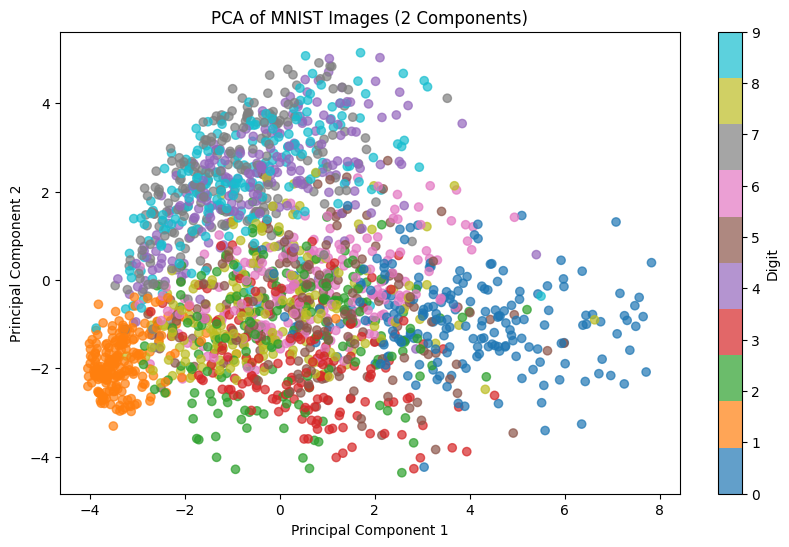

In [80]:
from sklearn.decomposition import PCA

# use a subset of the dataset for PCA to save computation time
num_pca_samples = 2000
indices = np.random.choice(len(mnist_dataset), num_pca_samples, replace=False)
images = []
labels_pca = []
for idx in indices:
    img_sample, label_sample = mnist_dataset[idx]
    images.append(img_sample.flatten().numpy())
    labels_pca.append(label_sample)

images = np.array(images)
labels_pca = np.array(labels_pca)

pca = PCA(n_components=2)
images_pca = pca.fit_transform(images)

plt.figure(figsize=(10,6))
scatter = plt.scatter(images_pca[:, 0], images_pca[:, 1], c=labels_pca, cmap='tab10', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of MNIST Images (2 Components)')
plt.colorbar(scatter, ticks=range(10), label='Digit')
plt.show()

## Conclusion

In this notebook, we performed a variety of EDA steps on the MNIST dataset and analyzed the effects of several image transformations on a custom CNN's output. We looked at:

- Various image transformations (rotation, cropping, masking, noise, brightness adjustment) and their impact on the CNN's predictions.
- The distribution of labels in the dataset.
- Sample images from each class to understand visual diversity.
- The pixel intensity distribution and PCA visualization to gain insights into the data structure.

These EDA steps help us understand the dataset better and guide us in building more robust CNN models.